In [3]:
#Import libraries
import pandas as pd                 
import matplotlib.pyplot as plt      
import numpy as np
import theano 
import keras 
import tensorflow
%matplotlib inline
from sklearn import metrics
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
#visualization
import seaborn as sns 
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dropout, Flatten, Activation, Dense
from keras.layers.convolutional import Convolution2D, Convolution1D,MaxPooling1D
#Import models from scikit learn module:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold   #For cross validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

Using TensorFlow backend.


In [4]:
df = pd.read_csv("data.csv",header=0)
df.shape

(569, 33)

In [5]:
df = df.sample(n=30000 , replace=True)
df.shape

(30000, 33)

In [6]:
df.drop('id',axis=1,inplace=True)
df.drop('Unnamed: 32',axis=1,inplace=True)
len(df) #size

30000

In [7]:
df.diagnosis.unique()
df['diagnosis'] = df['diagnosis'].map({'M':1,'B':0})
df.head(5)

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
86,1,14.48,21.46,94.25,648.2,0.09444,0.09947,0.120400,0.049380,0.2075,...,16.21,29.25,108.40,808.9,0.13060,0.19760,0.33490,0.1225,0.3020,0.06846
322,0,12.86,13.32,82.82,504.8,0.11340,0.08834,0.038000,0.034000,0.1543,...,14.04,21.08,92.80,599.5,0.15470,0.22310,0.17910,0.1155,0.2382,0.08553
95,1,20.26,23.03,132.40,1264.0,0.09078,0.13130,0.146500,0.086830,0.2095,...,24.22,31.59,156.10,1750.0,0.11900,0.35390,0.40980,0.1573,0.3689,0.08368
308,0,13.50,12.71,85.69,566.2,0.07376,0.03614,0.002758,0.004419,0.1365,...,14.97,16.94,95.48,698.7,0.09023,0.05836,0.01379,0.0221,0.2267,0.06192
330,1,16.03,15.51,105.80,793.2,0.09491,0.13710,0.120400,0.070410,0.1782,...,18.76,21.98,124.30,1070.0,0.14350,0.44780,0.49560,0.1981,0.3019,0.09124


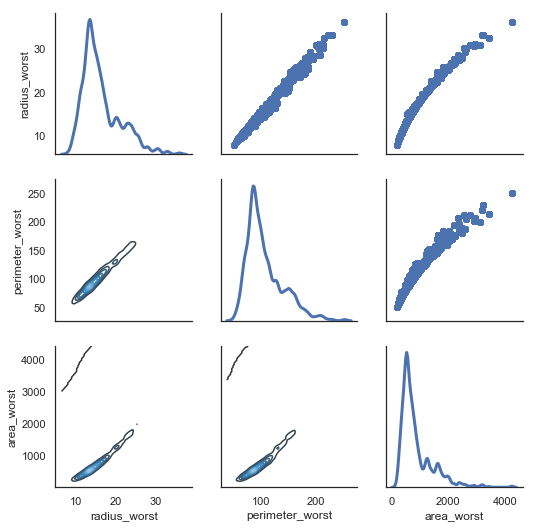

In [26]:
sns.set(style="white")
df = df.loc[:,['radius_worst','perimeter_worst','area_worst']]
g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

In [8]:
num_obs = len(df)
print (num_obs)
num_true = len(df.loc[df['diagnosis'] == 1])
num_false = len(df.loc[df['diagnosis'] == 0])
print("Number of Malignant cases:  {0} ({1:2.2f}%)".format(num_true, (float (num_true)/num_obs) * 100))
print("Number of Benign cases: {0} ({1:2.2f}%)".format(num_false, (float(num_false)/num_obs) * 100))

30000
Number of Malignant cases:  11112 (37.04%)
Number of Benign cases: 18888 (62.96%)


In [9]:
from sklearn.model_selection import train_test_split
feature_col_names = ['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']
predicted_class_names = ['diagnosis']
X = df[feature_col_names].values     
y = df[predicted_class_names].values 
split_test_size = 0.30 #That is use 30% data as test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_test_size, random_state=42) 


# Logistic Regression

In [11]:
#Logistic Regression
#from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train, y_train)
y_pred=clf.predict(X_test)

clf.predict_proba(X_test) 
#print(clf.predict_proba(X_test) )

print("Score:",clf.score(X_test, y_test))

Score: 0.9454444444444444


C:\Users\Upendra\AppData\Local\conda\conda\envs\DeepLearningEnv\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\Upendra\AppData\Local\conda\conda\envs\DeepLearningEnv\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


# Random Forest

In [17]:
clf=RandomForestClassifier(n_estimators=100,random_state=84)
clf.fit(X_train,y_train)
y_pred=clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
#print(y_pred)

C:\Users\Upendra\AppData\Local\conda\conda\envs\DeepLearningEnv\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy: 1.0


# Deep Neural Net

In [18]:
model = Sequential()
model.add(Dense(512, input_dim=30, init='uniform', activation='sigmoid'))
model.add(Dense(1, init='uniform', activation='relu'))

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\Upendra\AppData\Local\conda\conda\envs\DeepLearningEnv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(512, input_dim=30, activation="sigmoid", kernel_initializer="uniform")`
  
C:\Users\Upendra\AppData\Local\conda\conda\envs\DeepLearningEnv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, activation="relu", kernel_initializer="uniform")`
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [20]:
model.fit(X_train, y_train, epochs=600, batch_size=512,  verbose=2 ,validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 21000 samples, validate on 9000 samples
Epoch 1/600
 - 0s - loss: 0.0758 - acc: 0.8946 - val_loss: 0.0542 - val_acc: 0.9346
Epoch 2/600
 - 0s - loss: 0.0538 - acc: 0.9304 - val_loss: 0.0483 - val_acc: 0.9384
Epoch 3/600
 - 0s - loss: 0.0494 - acc: 0.9364 - val_loss: 0.0588 - val_acc: 0.9349
Epoch 4/600
 - 0s - loss: 0.0498 - acc: 0.9344 - val_loss: 0.0436 - val_acc: 0.9391
Epoch 5/600
 - 0s - loss: 0.0450 - acc: 0.9400 - val_loss: 0.0629 - val_acc: 0.9248
Epoch 6/600
 - 0s - loss: 0.0438 - acc: 0.9417 - val_loss: 0.0701 - val_acc: 0.9138
Epoch 7/600
 - 0s - loss: 0.0474 - acc: 0.9397 - val_loss: 0.0362 - val_acc: 0.9553
Epoch 8/600
 - 0s - loss: 0.0375 - acc: 0.9503 - val_loss: 0.0631 - val_acc: 0.9250
Epoch 9/600
 - 0s - loss: 0.0417 - acc: 0.9444 - val_loss: 0.0678 - val_acc: 0.9137
Epoch 10/600
 - 0s - loss: 0.0383 - acc: 0.9491 - val_loss: 0.0336 - val_acc: 0.9610
Epoch 11/600
 - 0s - loss: 0.0337 - acc: 0.9559 - val_loss: 0.

Epoch 94/600
 - 0s - loss: 0.0256 - acc: 0.9671 - val_loss: 0.0225 - val_acc: 0.9740
Epoch 95/600
 - 0s - loss: 0.0195 - acc: 0.9754 - val_loss: 0.0322 - val_acc: 0.9550
Epoch 96/600
 - 0s - loss: 0.0197 - acc: 0.9770 - val_loss: 0.0182 - val_acc: 0.9826
Epoch 97/600
 - 0s - loss: 0.0174 - acc: 0.9802 - val_loss: 0.0179 - val_acc: 0.9763
Epoch 98/600
 - 0s - loss: 0.0174 - acc: 0.9802 - val_loss: 0.0505 - val_acc: 0.9407
Epoch 99/600
 - 0s - loss: 0.0254 - acc: 0.9690 - val_loss: 0.0190 - val_acc: 0.9801
Epoch 100/600
 - 0s - loss: 0.0184 - acc: 0.9788 - val_loss: 0.0262 - val_acc: 0.9650
Epoch 101/600
 - 0s - loss: 0.0211 - acc: 0.9738 - val_loss: 0.0207 - val_acc: 0.9758
Epoch 102/600
 - 0s - loss: 0.0173 - acc: 0.9798 - val_loss: 0.0471 - val_acc: 0.9364
Epoch 103/600
 - 0s - loss: 0.0247 - acc: 0.9692 - val_loss: 0.0715 - val_acc: 0.9180
Epoch 104/600
 - 0s - loss: 0.0268 - acc: 0.9673 - val_loss: 0.0198 - val_acc: 0.9757
Epoch 105/600
 - 0s - loss: 0.0170 - acc: 0.9802 - val_loss:

Epoch 190/600
 - 0s - loss: 0.0172 - acc: 0.9815 - val_loss: 0.0168 - val_acc: 0.9891
Epoch 191/600
 - 0s - loss: 0.0137 - acc: 0.9861 - val_loss: 0.0241 - val_acc: 0.9679
Epoch 192/600
 - 0s - loss: 0.0158 - acc: 0.9829 - val_loss: 0.0169 - val_acc: 0.9838
Epoch 193/600
 - 0s - loss: 0.0141 - acc: 0.9862 - val_loss: 0.0229 - val_acc: 0.9716
Epoch 194/600
 - 0s - loss: 0.0155 - acc: 0.9832 - val_loss: 0.0237 - val_acc: 0.9683
Epoch 195/600
 - 0s - loss: 0.0157 - acc: 0.9829 - val_loss: 0.0187 - val_acc: 0.9779
Epoch 196/600
 - 0s - loss: 0.0147 - acc: 0.9851 - val_loss: 0.0172 - val_acc: 0.9783
Epoch 197/600
 - 0s - loss: 0.0180 - acc: 0.9795 - val_loss: 0.0206 - val_acc: 0.9722
Epoch 198/600
 - 0s - loss: 0.0139 - acc: 0.9861 - val_loss: 0.0153 - val_acc: 0.9857
Epoch 199/600
 - 0s - loss: 0.0132 - acc: 0.9869 - val_loss: 0.0161 - val_acc: 0.9802
Epoch 200/600
 - 0s - loss: 0.0144 - acc: 0.9854 - val_loss: 0.0169 - val_acc: 0.9807
Epoch 201/600
 - 0s - loss: 0.0148 - acc: 0.9850 - val

Epoch 286/600
 - 0s - loss: 0.0169 - acc: 0.9789 - val_loss: 0.0317 - val_acc: 0.9534
Epoch 287/600
 - 0s - loss: 0.0204 - acc: 0.9765 - val_loss: 0.0271 - val_acc: 0.9603
Epoch 288/600
 - 0s - loss: 0.0169 - acc: 0.9790 - val_loss: 0.0160 - val_acc: 0.9823
Epoch 289/600
 - 0s - loss: 0.0158 - acc: 0.9805 - val_loss: 0.0160 - val_acc: 0.9891
Epoch 290/600
 - 0s - loss: 0.0151 - acc: 0.9847 - val_loss: 0.0237 - val_acc: 0.9657
Epoch 291/600
 - 0s - loss: 0.0168 - acc: 0.9783 - val_loss: 0.0180 - val_acc: 0.9746
Epoch 292/600
 - 0s - loss: 0.0153 - acc: 0.9838 - val_loss: 0.0182 - val_acc: 0.9728
Epoch 293/600
 - 0s - loss: 0.0157 - acc: 0.9818 - val_loss: 0.0203 - val_acc: 0.9742
Epoch 294/600
 - 0s - loss: 0.0162 - acc: 0.9799 - val_loss: 0.0195 - val_acc: 0.9773
Epoch 295/600
 - 0s - loss: 0.0176 - acc: 0.9776 - val_loss: 0.0162 - val_acc: 0.9786
Epoch 296/600
 - 0s - loss: 0.0151 - acc: 0.9830 - val_loss: 0.0581 - val_acc: 0.9239
Epoch 297/600
 - 0s - loss: 0.0288 - acc: 0.9628 - val

Epoch 382/600
 - 0s - loss: 0.0211 - acc: 0.9736 - val_loss: 0.0160 - val_acc: 0.9786
Epoch 383/600
 - 0s - loss: 0.0146 - acc: 0.9829 - val_loss: 0.0149 - val_acc: 0.9809
Epoch 384/600
 - 0s - loss: 0.0145 - acc: 0.9837 - val_loss: 0.0262 - val_acc: 0.9686
Epoch 385/600
 - 0s - loss: 0.0164 - acc: 0.9823 - val_loss: 0.0291 - val_acc: 0.9623
Epoch 386/600
 - 0s - loss: 0.0167 - acc: 0.9793 - val_loss: 0.0391 - val_acc: 0.9508
Epoch 387/600
 - 0s - loss: 0.0242 - acc: 0.9731 - val_loss: 0.0151 - val_acc: 0.9836
Epoch 388/600
 - 0s - loss: 0.0140 - acc: 0.9845 - val_loss: 0.0157 - val_acc: 0.9783
Epoch 389/600
 - 0s - loss: 0.0142 - acc: 0.9836 - val_loss: 0.0157 - val_acc: 0.9764
Epoch 390/600
 - 0s - loss: 0.0144 - acc: 0.9822 - val_loss: 0.0165 - val_acc: 0.9764
Epoch 391/600
 - 0s - loss: 0.0141 - acc: 0.9847 - val_loss: 0.0243 - val_acc: 0.9674
Epoch 392/600
 - 0s - loss: 0.0159 - acc: 0.9810 - val_loss: 0.0157 - val_acc: 0.9803
Epoch 393/600
 - 0s - loss: 0.0145 - acc: 0.9836 - val

Epoch 478/600
 - 0s - loss: 0.0181 - acc: 0.9790 - val_loss: 0.0182 - val_acc: 0.9833
Epoch 479/600
 - 0s - loss: 0.0145 - acc: 0.9853 - val_loss: 0.0156 - val_acc: 0.9848
Epoch 480/600
 - 0s - loss: 0.0151 - acc: 0.9830 - val_loss: 0.0343 - val_acc: 0.9503
Epoch 481/600
 - 0s - loss: 0.0181 - acc: 0.9793 - val_loss: 0.0157 - val_acc: 0.9827
Epoch 482/600
 - 0s - loss: 0.0145 - acc: 0.9847 - val_loss: 0.0179 - val_acc: 0.9759
Epoch 483/600
 - 0s - loss: 0.0144 - acc: 0.9853 - val_loss: 0.0297 - val_acc: 0.9569
Epoch 484/600
 - 0s - loss: 0.0180 - acc: 0.9784 - val_loss: 0.0164 - val_acc: 0.9848
Epoch 485/600
 - 0s - loss: 0.0146 - acc: 0.9840 - val_loss: 0.0219 - val_acc: 0.9659
Epoch 486/600
 - 0s - loss: 0.0149 - acc: 0.9848 - val_loss: 0.0159 - val_acc: 0.9824
Epoch 487/600
 - 0s - loss: 0.0143 - acc: 0.9862 - val_loss: 0.0159 - val_acc: 0.9848
Epoch 488/600
 - 0s - loss: 0.0141 - acc: 0.9861 - val_loss: 0.0303 - val_acc: 0.9644
Epoch 489/600
 - 0s - loss: 0.0178 - acc: 0.9785 - val

Epoch 574/600
 - 0s - loss: 0.0140 - acc: 0.9849 - val_loss: 0.0164 - val_acc: 0.9781
Epoch 575/600
 - 0s - loss: 0.0133 - acc: 0.9870 - val_loss: 0.0578 - val_acc: 0.9342
Epoch 576/600
 - 0s - loss: 0.0260 - acc: 0.9709 - val_loss: 0.0183 - val_acc: 0.9762
Epoch 577/600
 - 0s - loss: 0.0131 - acc: 0.9865 - val_loss: 0.0144 - val_acc: 0.9848
Epoch 578/600
 - 0s - loss: 0.0129 - acc: 0.9875 - val_loss: 0.0174 - val_acc: 0.9741
Epoch 579/600
 - 0s - loss: 0.0134 - acc: 0.9863 - val_loss: 0.0339 - val_acc: 0.9663
Epoch 580/600
 - 0s - loss: 0.0174 - acc: 0.9817 - val_loss: 0.0248 - val_acc: 0.9674
Epoch 581/600
 - 0s - loss: 0.0142 - acc: 0.9849 - val_loss: 0.0161 - val_acc: 0.9804
Epoch 582/600
 - 0s - loss: 0.0127 - acc: 0.9872 - val_loss: 0.0151 - val_acc: 0.9852
Epoch 583/600
 - 0s - loss: 0.0129 - acc: 0.9874 - val_loss: 0.0156 - val_acc: 0.9824
Epoch 584/600
 - 0s - loss: 0.0131 - acc: 0.9863 - val_loss: 0.0193 - val_acc: 0.9752
Epoch 585/600
 - 0s - loss: 0.0152 - acc: 0.9846 - val

In [24]:
# estimate accuracy on whole dataset using loaded weights
scores = model.evaluate(X_train, y_train, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 98.05%
